# Prerequisites

In [1]:
%matplotlib inline
%run fcast.py

# customize matplotlib plots
mpl.style.use('seaborn-darkgrid')
plt.rc('font', family='TH Sarabun New')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes',  labelsize=16)
plt.rc('figure', figsize=(6.5,4), dpi=300)

# Prepare Data

In [2]:
hml = read_price('hml')
hml.meta = SimpleNamespace()
hml.meta.abb = 'hml'
hml.meta.shortname = 'ข้าวหอมมะลิ'
hml.meta.fullname = 'ราคาข้าวเปลือกหอมมะลิ ที่เกษตรกรขายได้ ณ ไร่นา'

wht = read_price('wht')
wht.meta = SimpleNamespace()
wht.meta.abb = 'wht'
wht.meta.shortname = 'ข้าวเจ้าขาว'
wht.meta.fullname = 'ราคาข้าวเปลือกเจ้าขาว ที่เกษตรกรขายได้ ณ ไร่นา'

glu = read_price('glu')
glu.meta = SimpleNamespace()
glu.meta.abb = 'glu'
glu.meta.shortname = 'ข้าวเหนียว'
glu.meta.fullname = 'ราคาข้าวเปลือกเหนียวเมล็ดยาว ที่เกษตรกรขายได้ ณ ไร่นา'

prices = [hml, wht, glu]

In [3]:
n_diff = 1

for price in prices:
    price.scaled, price.scaler = data_transform(price, method='minmax')
    price.scaled_diff, price.correction = data_difference(price.scaled, n_diff)
    price.train, price.validate, price.train2, price.test = data_split(price.scaled_diff)

# LSTM

## Define functions
- lstm_fit
- lstm_forecast
- lstm_walk_forward

In [4]:
def lstm_fit(data, config, n_forecast=4):
    
    # unpack config
    n_lag, n_layers, n_nodes, n_epochs, n_batch, refit_rate = config
    
    # transform to kreas format
    x, y, date_idx = data_2keras(data, n_lag=n_lag, n_forecast=n_forecast)
    x = x.to_numpy()
    y = y.to_numpy()
    x = x.reshape((x.shape[0], x.shape[1], 1))

    # define model
    if n_layers!=1:
        model = Sequential()
        model.add(LSTM(n_nodes, activation='relu', input_shape=(n_lag+1, 1)))
        model.add(Dense(n_forecast))
        model.compile(loss='mse', optimizer='adam')
    else:
        model = Sequential()
        model.add(LSTM(n_nodes, activation='relu', input_shape=(n_lag+1, 1)))
        model.add(Dense(n_nodes, activation='relu'))
        model.add(Dense(n_forecast))
        model.compile(loss='mse', optimizer='adam')
    
    # fit model
    model.fit(x, y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    
    return model


def lstm_forecast(model_fitted, data, date, n_forecast=4):
    """
    Forecast LSTM model
    
    Args:
        model_fitted (model): Keras fitted model
        data (dataframe): number of lags to be used in the model
        date (date): first date to forecast
        n_fcast (int): number of steps to forecast
    
    Returns:
        
    """
    scaler = getattr(data, "scaler")
    correction = getattr(data, "correction")
    
    x_idx = data.scaled_diff.index.get_loc(date)
    n_input = model_fitted.input_shape[1]
    
    # find-input
    x = data.scaled_diff.iloc[x_idx-n_input:x_idx,].to_numpy()
    x_input = x.reshape((1, x.shape[0], 1))

    # forecast
    yhat = model_fitted.predict(x_input, verbose=0).reshape(-1,)
    K.clear_session()
    df = pd.DataFrame(yhat,
                      columns=["yhat_scaled"],
                      index=pd.date_range(date, periods=n_forecast, freq='MS')
                     )
    df['yhat_scaled'] = inverse_difference(df["yhat_scaled"], correction['y']).dropna()
    df['yhat'] = scaler.inverse_transform(df)
    
    return df['yhat']


def lstm_walk_forward(data, config, search_mode=False, n_forecast=4):
    
    train, test = select_traintest(data, search_mode)
    n_test = test.shape[0]
    n_yhat = n_test-n_forecast+1
    yhat = np.empty((n_yhat, n_forecast))
    refit_rate = config[-1]
    history = train
    model_fitted = lstm_fit(history, config)
    
    for i in range(n_yhat):
        date = test.index[i]
        model_fitted = lstm_fit(history, config) if i%refit_rate==0 else model_fitted 
        yhat[i] = lstm_forecast(model_fitted, data, date, n_forecast=n_forecast)
        history = history.append(test.iloc[i])
        
    yhat = pd.DataFrame(yhat,
                        columns=[f'yhat{h}' for h in range(1, n_forecast+1)],
                        index=test.iloc[:n_yhat,].index)
    
    return yhat

## Generate Parameter Grid

In [5]:
n_input = [5, 11, 17]
n_layers = [1, 2]
n_nodes = [10, 20]
n_epochs = [5, 10, 20, 50]
n_batch = [64]
refit_rate = [1, 4, 12, np.inf]

lstm_configs = model_configs(n_input, n_layers, n_nodes, n_epochs, n_batch, refit_rate)
lstm_model = [lstm_fit, lstm_forecast, lstm_walk_forward, lstm_configs]

In [ ]:
%%time
n_forecast = 4
npr.seed(1305)
for price in prices:
    price.lstm_grid_result, price.lstm_config = grid_search(price, lstm_model, n_forecast=n_forecast)
    price.lstm_yhat = forecast(price, lstm_model, price.lstm_config, n_forecast=n_forecast)

In [18]:
for i in prices:
    config = "-".join((str(j) for j in i.lstm_config))
    print(config, '\n', i.lstm_grid_result.loc[config])

5-2-20-10-64-inf 
 rmse   694.0888
mae    398.0416
mape     0.0310
Name: 5-2-20-10-64-inf, dtype: float64
17-2-20-50-64-inf 
 rmse   593.0665
mae    330.1567
mape     0.0355
Name: 17-2-20-50-64-inf, dtype: float64
17-2-10-20-64-inf 
 rmse   721.7177
mae    520.9508
mape     0.0520
Name: 17-2-10-20-64-inf, dtype: float64


In [19]:
model_measure(hml, hml.lstm_yhat, ['hml'])

,rmse,mae,mape
config,,,
hml,501.2305,346.4744,0.0281


In [20]:
model_measure(wht, wht.lstm_yhat, ['whit'])

,rmse,mae,mape
config,,,
whit,284.5055,215.3686,0.0268


In [21]:
model_measure(glu, glu.lstm_yhat, ['glu'])

,rmse,mae,mape
config,,,
glu,525.1024,366.2267,0.0335


In [22]:
path = '../results/result_lstm_4.pkl'
result = dict()

if(os.path.isfile(path)):
    result = joblib.load(path)
else:
    for price in prices:
        result[price.meta.abb] = [price.lstm_grid_result, price.lstm_config, price.lstm_yhat]
    joblib.dump(result, path)

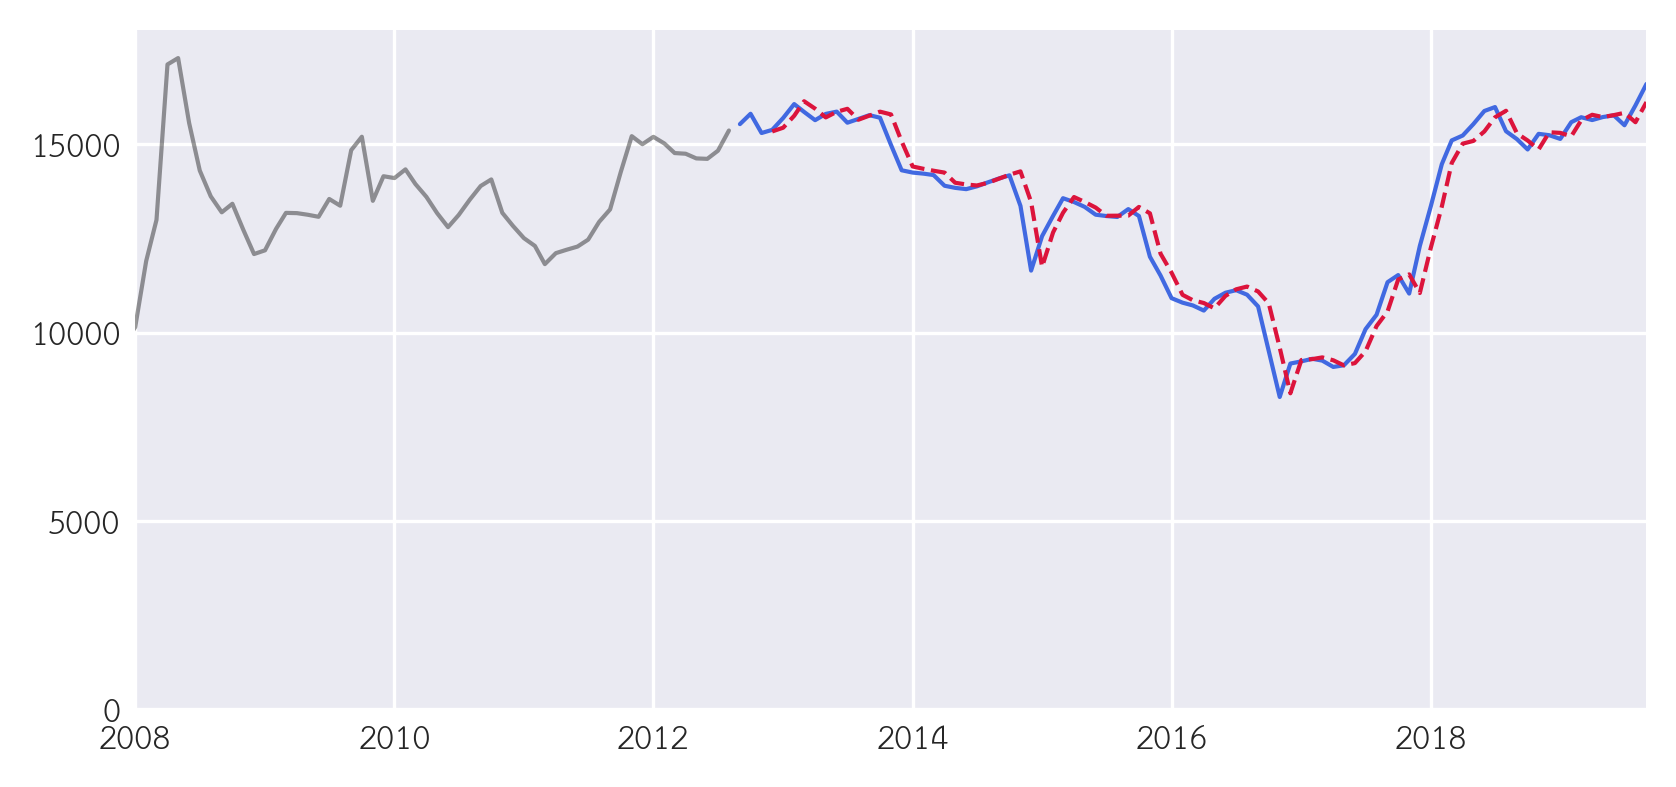

In [26]:
plot_fcast(hml, 'lstm', step=4)

In [12]:
hml.lstm_config

(12, 2, 20, 50, 150, inf)

In [13]:
wht.lstm_config

(6, 1, 20, 50, 50, inf)

In [14]:
glu.lstm_config

(6, 1, 20, 50, 150, inf)